In [1]:
import pandas as pd

import torch
from diffusers import StableDiffusion3Pipeline

In [19]:
def flatten_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [2]:
TTI_MODEL = "stabilityai/stable-diffusion-3.5-medium"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load dataset for evaluation
controlled_benchmark = {
    # ---------------------------------------------------------
    # HIERARCHY 1: ONE OBJECT ONLY
    # Sampled directly from the DeepMind paper taxonomy (Figure 2)
    # ---------------------------------------------------------
    "one_object_only": {
        "human_made_object": [
            "a door", "a desk", "a table", "a pair of sunglasses", "a teddy bear",
            "a vase", "a truck", "an umbrella", "a train", "a soda can",
            "a window", "a ring", "a road", "a spoon", "a pair of scissors",
            "a pair of shoes", "a smartphone", "a pair of socks", "a bus", "a building",
            "a bridge", "an airplane", "a pillow", "a telephone", "a pencil",
            "a painting", "a glass", "a mug", "a necklace", "a house"
        ],
        "nature": [
            "an animal", "a bird", "an island", "a horse", "a leaf",
            "a lion", "a mountain", "a mushroom", "an ocean", "an orange",
            "the moon", "a giraffe", "a lake", "a forest", "a butterfly",
            "a flower", "a fish", "an elephant", "a dog", "a tiger",
            "a tree", "a waterfall", "the sun", "a whale", "a star",
            "rain", "a plant", "a rabbit", "a river", "a rock"
        ],
        "food_and_drinks": [
            # First 10 from the original paper's taxonomy
            "a teapot", "a cucumber", "a dessert", "a coffee cup", "a piece of cheese",
            "a cake", "a fruit", "a pizza", "a loaf of bread", "an apple",
            # Augmented with 20 additional items to reach 30
            "a sandwich", "a burger", "a taco", "sushi", "a bowl of salad",
            "a steak", "a bowl of pasta", "a donut", "a cookie", "a muffin",
            "a waffle", "a pancake", "a croissant", "a bagel", "french fries",
            "a chocolate bar", "popcorn", "a bowl of rice", "noodles", "a milkshake"
        ]
    },

    # ---------------------------------------------------------
    # HIERARCHY 2: TWO OBJECT INTERACTION
    # Combinations of two distinct categories
    # ---------------------------------------------------------
    "two_object_interaction": {
        "man_made_object_x_nature": [
            "a house at the foot of a mountain",
            "a bridge crossing a river",
            "an umbrella shading a dog",
            "a boat floating on the ocean",
            "a road winding through a forest",
            "a kite flying near the sun",
            "a train passing a waterfall",
            "a bench under a tree",
            "a car parked near a lake",
            "a plane flying above the clouds",
            "a fence surrounding a garden",
            "a cabin on an island",
            "a camera capturing a lion",
            "a bicycle leaning against a rock",
            "a streetlamp illuminating the rain",
            "a bucket collecting rain",
            "a drone hovering over a forest",
            "a tent set up in a valley",
            "a tire swing hanging from a tree",
            "a lighthouse overlooking the sea",
            "a signpost pointing to a cave",
            "a balloon stuck in a tree",
            "a surfboard resting on the sand",
            "a windmill standing in a field",
            "a scarecrow protecting crops",
            "a pier extending into the water",
            "a satellite dish facing the sky",
            "a jeep driving through a desert",
            "a birdhouse hanging from a branch",
            "a telescope pointed at the moon"
        ],
        "man_made_object_x_food_and_drinks": [
            "a spoon resting on a cake",
            "a soda can next to a pizza",
            "a knife slicing bread",
            "a mug filled with coffee",
            "a plate holding a sandwich",
            "a napkin under a donut",
            "a vending machine dispensing a snack",
            "a blender mixing a smoothie",
            "a toaster heating a bagel",
            "a fork piercing a steak",
            "a lunchbox containing an apple",
            "a tray carrying sushi",
            "a candle on top of a cupcake",
            "a basket full of fruit",
            "a refrigerator stocked with drinks",
            "a table set with dinner",
            "a painting of a bowl of fruit",
            "a jar filled with cookies",
            "a wrapper covering a chocolate bar",
            "a glass of milk next to a cookie",
            "a spatula flipping a pancake",
            "a grill cooking a burger",
            "a microwave heating popcorn",
            "a bowl holding cereal",
            "a thermos kept next to a lunch",
            "a menu listing desserts",
            "a receipt for a meal",
            "a shopping cart filled with groceries",
            "a picnic blanket with a spread of food",
            "a desk cluttered with snacks"
        ],
        "nature_x_food_and_drinks": [
            "a rabbit eating a carrot",
            "a bird pecking at bread crumbs",
            "an apple falling from a tree",
            "a fish swimming near seaweed",
            "a bear eating honey",
            "ants marching toward a picnic",
            "a squirrel holding a nut",
            "a bee landing on a sugary drink",
            "grapes growing on a vine",
            "mushrooms growing near wild berries",
            "a coconut falling on the sand",
            "a monkey holding a banana",
            "a cow grazing in a field",
            "a mouse nibbling on cheese",
            "a seagull stealing a french fry",
            "a raccoon rummaging for scraps",
            "berries ripening in the sun",
            "a watermelon cooling in a river",
            "a corn stalk growing in the rain",
            "a pineapple growing in the soil",
            "a panda eating bamboo",
            "a hummingbird drinking nectar",
            "a caterpillar on a leaf of lettuce",
            "a dog begging for a treat",
            "a goat chewing on a tin can label",
            "salmon leaping upstream",
            "a lemon tree blossoming",
            "a pumpkin patch in autumn",
            "wheat swaying in the wind",
            "a campfire roasting marshmallows"
        ]
    },

    # ---------------------------------------------------------
    # HIERARCHY 3: THREE OBJECT INTERACTION
    # Combinations involving Human-made, Nature, and Food & Drink
    # ---------------------------------------------------------
    "three_object_interaction": {
        "all_three_categories": [
            "a person eating a sandwich on a park bench under a tree",
            "a bottle of water resting on a rock near a river",
            "a bird stealing a fry from a table",
            "a basket of apples sitting on the grass",
            "a tent pitched near a fire cooking fish",
            "a car parked in a field with a pizza on the roof",
            "a dog eating food from a bowl on the porch",
            "a glass of lemonade on a patio table in the sun",
            "a drawing of a fruit bowl with a mountain background",
            "a squirrel eating a nut on a wooden fence",
            "a boat on a lake with a cooler of drinks",
            "a cake sitting on a stump in the forest",
            "a hiker eating a granola bar on a trail",
            "a picnic blanket on the grass with a basket of food",
            "a mug of coffee on a balcony overlooking the ocean",
            "a bear rummaging through a dumpster for leftovers",
            "a fishing rod resting against a tree near a bucket of fish",
            "a wedding cake on a table in a garden",
            "a grill cooking burgers in a backyard",
            "a hammock tied between trees with a drink nearby",
            "a vending machine in a park selling sodas",
            "a farmer harvesting corn with a tractor",
            "a photographer taking a picture of a fruit tree",
            "a child holding an ice cream cone on a swing set",
            "a plate of cookies on a windowsill with a view of the rain",
            "a street vendor selling hot dogs under an umbrella",
            "a tea set arranged on a rock in a zen garden",
            "a painting of a landscape with a bowl of fruit in the foreground",
            "a cat drinking milk from a saucer on a rug",
            "a bicycle basket filled with flowers and a baguette",
            "a teddy bear having a picnic with a rabbit and a slice of cake",
            "a truck driving through a forest carrying crates of oranges",
            "a pair of sunglasses resting on a rock next to a cocktail",
            "a bird perched on a streetlamp pecking at a donut",
            "a boat floating on the ocean filled with boxes of pizza",
            "a painting of a mountain range with a bowl of fruit in the foreground",
            "a pair of shoes left on the grass near a plate of cheese",
            "a balloon tied to a tree branch hovering over a basket of muffins",
            "a bicycle leaning against a tree with a baguette in the basket",
            "a knife cutting a piece of cheese on a wooden stump",
            "a smartphone taking a photo of a waterfall and a milkshake",
            "a house at the edge of a lake with a pie cooling on the porch",
            "a train passing a field of cows while passengers eat sandwiches",
            "a ring placed on a flower petal next to a strawberry",
            "a pair of scissors cutting herbs in a garden for a salad",
            "a desk placed in a meadow with a cup of coffee on it",
            "a kite flying over a river with a child eating a popsicle nearby",
            "a key hidden under a leaf next to a dropped candy bar",
            "a lamp illuminating a dark cave where a bear eats honey",
            "a book left on a sandy beach next to a coconut drink",
            "a plane flying over a jungle dropping supplies of rice",
            "a vase of wildflowers sitting on a rock next to a picnic lunch",
            "a bus parked near a canyon with tourists eating tacos",
            "a pillow lying on a patch of moss with a box of chocolates",
            "a guitar leaning against a cactus near a bottle of tequila",
            "a soda can floating in a river past a swimming fish",
            "a pair of socks drying on a bush near a camping stove cooking beans",
            "a pencil sketching a lion while the artist eats an apple",
            "a necklace draped over a mushroom next to a raspberry",
            "a bridge crossing a stream with a vendor selling hot pretzels",
            "a road sign pointing toward a mountain and a diner serving burgers",
            "a spoon digging into a grapefruit sitting on a bed of leaves",
            "a window framing a view of a snowy pine tree and a cup of hot cocoa",
            "a glass of wine sitting on a log by a roaring campfire",
            "a building overgrown with vines housing a bakery selling croissants",
            "a headphones set resting on a pumpkin in a vegetable patch",
            "a hat blown by the wind into a puddle near a spilled ice cream",
            "a ball rolling down a hill past a grazing sheep and a picnic basket",
            "a telephone booth in the desert next to a vending machine for soda",
            "a door standing alone in a field opening to a banquet of roast chicken",
            "a drawing of a tiger eating a steak pinned to a tree",
            "a mug of tea sitting on a stone wall overlooking a valley",
            "a bowl of soup placed on a dock near a swimming duck",
            "a umbrella shielding a butterfly and a sugar cube from the rain",
            "a car trunk open in a forest revealing a stash of watermelon",
            "a candle lighting up a small cave where a mouse eats a crumb",
            "a clocktower rising above a park where people eat sushi",
            "a dress hanging from a branch swaying above a basket of grapes",
            "a computer set up on a stump in the woods displaying a recipe for pasta",
            "a container of leftovers sitting on a frozen lake near a penguin",
            "a toy truck stuck in the mud near a pig eating corn",
            "a pair of glasses reflecting the sun and a plate of waffles",
            "a mirror leaning against a barn reflecting a horse eating a carrot",
            "a ladder propped against an apple tree with a basket of harvest",
            "a suitcase open on a grassy hill filled with baguette sandwiches",
            "a traffic cone sitting in a puddle next to a discarded banana peel",
            "a camera lens focused on a squirrel holding a peanut",
            "a hammock strung between palms with a coconut split open nearby",
            "a mailbox filled with flowers and a delivery of cookies",
            "a skateboard resting on a curb near a pigeon eating a fry"
        ]
    }
}

controlled_one_object = pd.DataFrame(controlled_benchmark["one_object_only"]).melt(var_name="category", value_name="prompt")
controlled_two_object = pd.DataFrame(controlled_benchmark["two_object_interaction"]).melt(var_name="category", value_name="prompt")
controlled_three_object = pd.DataFrame(controlled_benchmark["three_object_interaction"]).melt(var_name="category", value_name="prompt")

controlled_benchmark_df = pd.concat([controlled_one_object, controlled_two_object, controlled_three_object])[["prompt", "category"]]

print(controlled_one_object.shape)
print(controlled_two_object.shape)
print(controlled_three_object.shape)
print(controlled_benchmark_df.shape)

controlled_benchmark_df.head(2)

(90, 2)
(90, 2)
(90, 2)
(270, 2)


,prompt,category
0,a door,human_made_object
1,a desk,human_made_object


In [ ]:
# controlled_benchmark_df.to_csv("controlled_benchmark.csv", index=False)

In [4]:
# Load TTI model
tti = StableDiffusion3Pipeline.from_pretrained(TTI_MODEL, torch_dtype=torch.bfloat16)
tti = tti.to(DEVICE)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

a wedding cake on a table in a garden


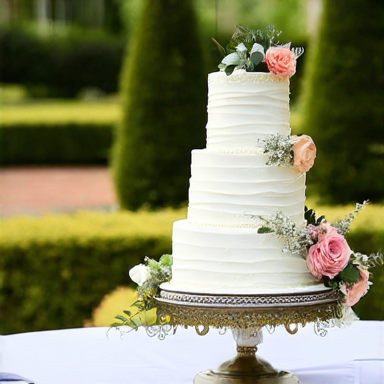

a painting


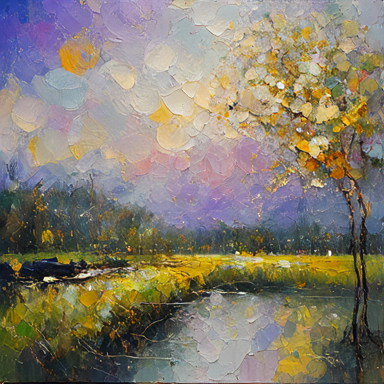

a waffle


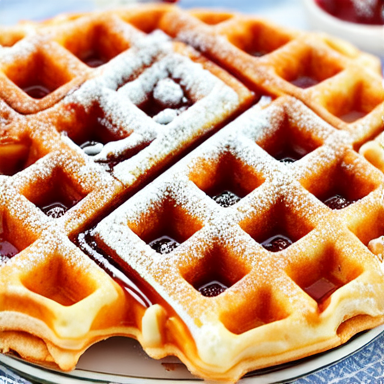

In [5]:
# Playtest
prompts = controlled_benchmark_df.sample(3)["prompt"].tolist()

image_height = 384
image_width = 384
noise_seed = 888
num_inference_steps = 50
guidance_scale = 7.0 # Default is 7.0

images = tti(
    prompts,
    height=image_height,
    width=image_width,
    generator=torch.Generator(DEVICE).manual_seed(noise_seed) if noise_seed is not None else None,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
)[0]

for prompt, image in zip(prompts, images):
    print(prompt)
    image.show()

## Baseline

### Manipulating noise seed

In [6]:
image_height = 384
image_width = 384
noise_seed = None # None means every generation is different
num_inference_steps = 50
guidance_scale = 7.0 # Default is 7.0

In [7]:
# Get prompts
prompts = controlled_benchmark_df["prompt"].tolist()

len(prompts)

270

In [ ]:
N_SAMPLES = 30
BATCH_SIZE = 16

for prompt in prompts:
    # Get prompts
    prompt_batch = [prompt for _ in range(N_SAMPLES)]
    generated_images = []
    for i in range(0, len(prompt_batch), BATCH_SIZE):
        # Generate variation of the same prompt
        images = tti(
            prompt_batch[i:i+BATCH_SIZE],
            height=image_height,
            width=image_width,
            generator=torch.Generator(DEVICE).manual_seed(noise_seed) if noise_seed is not None else None,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
        )[0]
        generated_images.append(images)
    generated_images = flatten_list(generated_images)

    break

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
ven

30

In [17]:
len(generated_images)

30

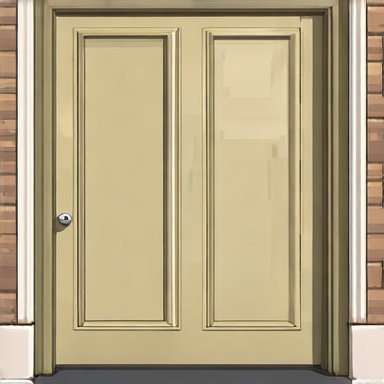

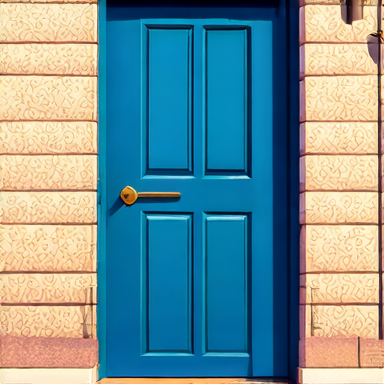

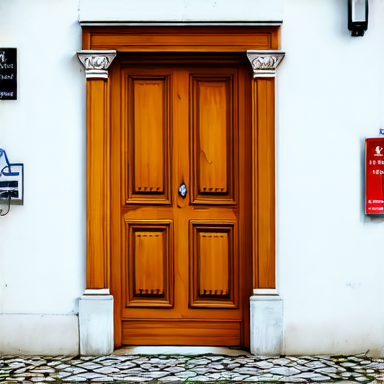

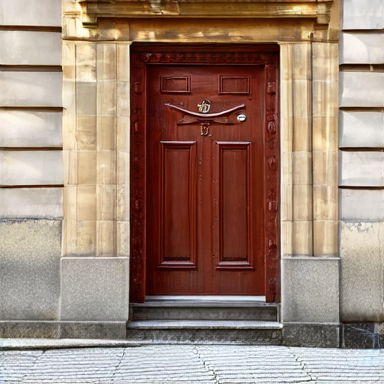

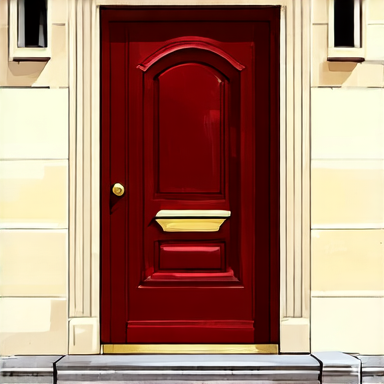

In [18]:
for image in generated_images[:5]:
    image.show()


In [ ]:

# Playtest
prompts = controlled_benchmark_df.sample(3)["prompt"].tolist()



images = tti(
    prompts,
    height=image_height,
    width=image_width,
    generator=torch.Generator("cuda").manual_seed(noise_seed) if noise_seed is not None else None,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
)[0]

for prompt, image in zip(prompts, images):
    print(prompt)
    image.show()

In [ ]:
# Playtest
prompts = controlled_benchmark_df.sample(3)["prompt"].tolist()

image_height = 512
image_width = 512
noise_seed = 888
num_inference_steps = 50
guidance_scale = 7.0 # Default is 7.0

images = tti(
    prompts,
    height=image_height,
    width=image_width,
    generator=torch.Generator("cuda").manual_seed(noise_seed) if noise_seed is not None else None,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
)[0]

for prompt, image in zip(prompts, images):
    print(prompt)
    image.show()